<a href="https://colab.research.google.com/github/felipemontano10/computervision/blob/master/hw4_felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### COMPSCI 527 - Spring 2020
## Homework 4
**Collaborators:**


> Haozhe Zhang 

> Felipe Montano-Campos





##### **Part 1: Dimensionality Reduction**

**Preliminary Code** 

In [0]:
import numpy as np
from sklearn.datasets import fetch_openml
import pickle
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import StandardScaler

In [0]:
def split_and_standardize(x, y, proportions=(6, 2, 2)):
    assert len(proportions) == 3, 'Need three numbers for proportions'
    for p in proportions:
        assert p >= 0., 'Proportions must be non-negative'
    s = float(sum(proportions))
    assert s != 0., 'Proportions cannot be all zero'
    ratios = [float(p) / s for p in proportions]
    test_ratio = ratios[2]
    assert test_ratio < 1., 'Cannot use all data for testing'
    if test_ratio > 0.:
        x_rest, x_test, y_rest, y_test = \
            train_test_split(x, y, test_size=test_ratio, random_state=0)
    else:
        x_rest, x_test, y_rest, y_test = x, None, y, None
    val_ratio = ratios[1] / (1. - test_ratio)
    assert val_ratio < 1., 'Need some data for training'
    if val_ratio > 0.:
        x_train, x_val, y_train, y_val = \
            train_test_split(x_rest, y_rest, test_size=val_ratio, random_state=0)
    else:
        x_train, x_val, y_train, y_val = x_rest, None, y_rest, None
    train_set = SimpleNamespace(x=x_train, y=y_train)
    val_set = None if x_val is None else SimpleNamespace(x=x_val, y=y_val)
    test_set = None if x_test is None else SimpleNamespace(x=x_test, y=y_test)
    scaler = StandardScaler()
    train_set.x = scaler.fit_transform(train_set.x)
    val_set.x = scaler.transform(val_set.x)
    test_set.x = scaler.transform(test_set.x)
    return SimpleNamespace(train=train_set, validate=val_set, test=test_set)

In [0]:
pickle_file = 'data.pkl'
try:
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    print('Done reading the MNIST data set from local file {}'.format(pickle_file))
except IOError:
    print('Fetching the MNIST data set from the web. This may take a while... ', end='')
    x, y = fetch_openml('mnist_784', return_X_y=True)
    data = split_and_standardize(x, y)
    print('Done.\nStoring the data locally to file {} for later reuse. '.format(pickle_file), end='')
    with open(pickle_file, 'wb') as file:
        pickle.dump(data, file)
    print('Done.')

Fetching the MNIST data set from the web. This may take a while... Done.
Storing the data locally to file data.pkl for later reuse. Done.


In [0]:
from sklearn.linear_model import LogisticRegression

def train(train_set):
    np.random.seed(0)
    C = 50. / float(len(train_set.y))
    h = LogisticRegression(C=C, penalty='l1', solver='saga',
                           tol=0.01, multi_class='auto')
    h.fit(train_set.x, train_set.y)
    return h


def percent_accuracy(h, test_set):
    return h.score(test_set.x, test_set.y) * 100.


In [0]:
import time
start_time = time.time()

classifier = train(data.train)
baseline_accuracy = percent_accuracy(classifier, data.test)
fmt = 'Percent test accuracy of classifier on original data is {:.2f} percent'
print(fmt.format(baseline_accuracy))




print (time.time() - start_time, "seconds")



Percent test accuracy of classifier on original data is 83.00 percent
87.31909108161926 seconds


**Problem 1.1**

In [0]:
import numpy as np
from math import sqrt
import copy


In [0]:
def projection_matrices(rows,columns):
    matrix = np.random.randn(rows, columns)
    for i in list(range(columns)):
        matrix[:,i] = matrix[:,i] / (matrix[:,i]**2).sum()**0.5
    u, s, vh = np.linalg.svd(matrix, full_matrices=False)        
    return u, matrix     

In [0]:
np.random.seed(0)
U, R = projection_matrices(10000,4)
np.set_printoptions(precision=3)
print(R.T@R)

[[ 1.     0.014  0.004 -0.007]
 [ 0.014  1.     0.014 -0.009]
 [ 0.004  0.014  1.     0.011]
 [-0.007 -0.009  0.011  1.   ]]


Let's recall that an orthogonal matrix has column/rows vectors that are unit vectors and independent among each other. The matrix $R$ contains unit vector columns that were drawn from an independent identical normal distribution. So, we can state that they are nearly independent, hence $R$ is nearly orthogonal. Also, note that $R\times R^{T}\approx I$, supporting the idea that $R$ is nearly orthogonal. 

**Problem 1.2**

In [0]:
max_power = 9
dims = np.logspace(0, max_power, max_power + 1, base=2).astype(int)

In [0]:
def project(sets_in, dimensions, seed=0):
    np.random.seed(seed)
    U, R = projection_matrices(sets_in.train.x.shape[1], dimensions)
    new_data = copy.deepcopy(sets_in)  
    new_data.train.x = np.dot(new_data.train.x, U)
    new_data.test.x = np.dot(new_data.test.x, U)
    new_data.validate.x = np.dot(new_data.validate.x, U)
    return new_data

def percent_std_ratio(original_set, projected_set):
    svd_original_set = np.sqrt(np.sum(np.square(original_set.validate.x)))
    svd_projected_set = np.sqrt(np.sum(np.square(projected_set.validate.x)))
    result = (svd_projected_set/svd_original_set)*100
    return result
    print(result)

In [0]:
from tqdm import tqdm

ratio_list = []
score = []
for dimensions in tqdm(dims):
    projected_set = project(data,dimensions,seed=0)
    classifier = train(projected_set.train)
    baseline_accuracy = percent_accuracy(classifier, projected_set.validate)
    fmt = "The percent test accuracy of classifier is {:.2f} percent"
    print("Considering %d dimensions:" % (dimensions))
    print(fmt.format(baseline_accuracy))
    ratio = percent_std_ratio(data,projected_set)
    print("The percentaje of the standard deviation between the projected set and the original set is")
    print(ratio)
    ratio_list.append(ratio)
    score.append(baseline_accuracy)

 10%|█         | 1/10 [00:00<00:06,  1.31it/s]

Considering 1 dimensions:
The percent test accuracy of classifier is 18.66 percent
The percentaje of the standard deviation between the projected set and the original set is
3.641274017385703


 20%|██        | 2/10 [00:01<00:05,  1.34it/s]

Considering 2 dimensions:
The percent test accuracy of classifier is 23.86 percent
The percentaje of the standard deviation between the projected set and the original set is
4.9211910218761625


 30%|███       | 3/10 [00:02<00:05,  1.36it/s]

Considering 4 dimensions:
The percent test accuracy of classifier is 27.60 percent
The percentaje of the standard deviation between the projected set and the original set is
6.807040165114903


 40%|████      | 4/10 [00:03<00:04,  1.28it/s]

Considering 8 dimensions:
The percent test accuracy of classifier is 33.15 percent
The percentaje of the standard deviation between the projected set and the original set is
8.851954902034324


 50%|█████     | 5/10 [00:04<00:04,  1.12it/s]

Considering 16 dimensions:
The percent test accuracy of classifier is 50.38 percent
The percentaje of the standard deviation between the projected set and the original set is
15.443254843895987


 60%|██████    | 6/10 [00:06<00:04,  1.19s/it]

Considering 32 dimensions:
The percent test accuracy of classifier is 63.22 percent
The percentaje of the standard deviation between the projected set and the original set is
20.3839709729341


 70%|███████   | 7/10 [00:09<00:05,  1.99s/it]

Considering 64 dimensions:
The percent test accuracy of classifier is 69.73 percent
The percentaje of the standard deviation between the projected set and the original set is
28.347288044878844


 80%|████████  | 8/10 [00:22<00:10,  5.26s/it]

Considering 128 dimensions:
The percent test accuracy of classifier is 73.54 percent
The percentaje of the standard deviation between the projected set and the original set is
40.06190000830796


 90%|█████████ | 9/10 [00:56<00:13, 13.73s/it]

Considering 256 dimensions:
The percent test accuracy of classifier is 79.49 percent
The percentaje of the standard deviation between the projected set and the original set is
57.06734932306334


100%|██████████| 10/10 [02:19<00:00, 34.47s/it]

Considering 512 dimensions:
The percent test accuracy of classifier is 81.94 percent
The percentaje of the standard deviation between the projected set and the original set is
80.80924732498896


In [0]:
import matplotlib.pyplot as plt
hor = [83]*len(dims)



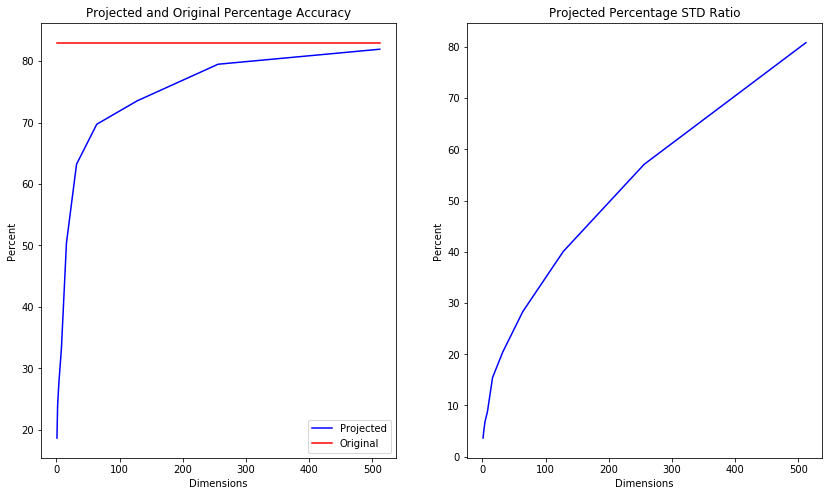

In [0]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize =(14,8))
axes[0].plot(dims, score, label = 'Projected', color ="blue")
axes[0].plot(dims, hor, label='Original', color = "red")
axes[0].set(title='Projected and Original Percentage Accuracy')
axes[0].legend()
axes[1].plot(dims, ratio_list, color = "blue")
axes[1].set(title='Projected Percentage STD Ratio')
for axis in axes:
    axis.set(xlabel = 'Dimensions', ylabel='Percent')

As we can see with this dimensionality reduction technique we have gains in computational efficiency (34 vs 87 seconds). Also, note that the percentage of standard deviation ratio drops significantly as we projected the original data into lower dimensions. 

However, we can not improve the quality of the classifications results, since we get a lower accurarcy (i.e., 80.8 vs. 83%). Actually, we pay the price of a lower accuracy and this can be seen from the left plot that none of the projected accuracy is above the original one.

**Problem 1.3**

In [0]:
from sklearn.decomposition import PCA

def pca_encoding(sets_in, dimensions):
    new_data = copy.deepcopy(sets_in)
    pca = PCA(svd_solver="full", n_components = dimensions)
    pca.fit(new_data.train.x)
    new_data.train.x = pca.transform(new_data.train.x)
    new_data.test.x = pca.transform(new_data.test.x)
    new_data.validate.x = pca.transform(new_data.validate.x)
    singular_values = pca.singular_values_
    return new_data, singular_values

In [0]:
shape = data.train.x.shape
n_samples = shape[0]
n_features = shape[1]
pca = PCA(svd_solver="full", n_components = min(n_samples, n_features))
pca.fit(data.train.x)
sin_values_full = pca.singular_values_
stdv_full = np.sqrt(np.sum(np.square(sin_values_full)))  

In [0]:
ratio_list_scnd = []
ratio_pca_scnd = []
score_scnd = []
for dimensions in tqdm(dims):
    projected_set, singular_values = pca_encoding(data,dimensions)
    classifier = train(projected_set.train)
    baseline_accuracy = percent_accuracy(classifier, projected_set.validate)
    fmt = "The percent test accuracy of classifier is {:.2f} percent"
    print("Considering %d dimensions:" % (dimensions))
    print(fmt.format(baseline_accuracy))
    ratio_1 = percent_std_ratio(data,projected_set)
    print("-> The percentaje of the standard deviation between the projected set and the original set is")
    print(ratio_1)
    ratio_2 = (np.sqrt(np.sum(np.square(singular_values)))/stdv_full)*100
    print("-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is")
    print(ratio_2)
    ratio_list_scnd.append(ratio_1)
    score_scnd.append(baseline_accuracy) 
    ratio_pca_scnd.append(ratio_2)

 10%|█         | 1/10 [00:09<01:26,  9.63s/it]

Considering 1 dimensions:
The percent test accuracy of classifier is 28.75 percent
-> The percentaje of the standard deviation between the projected set and the original set is
20.457453582520916
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
23.903162271918582


 20%|██        | 2/10 [00:19<01:17,  9.64s/it]

Considering 2 dimensions:
The percent test accuracy of classifier is 33.52 percent
-> The percentaje of the standard deviation between the projected set and the original set is
26.730691198228556
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
31.324260176841946


 30%|███       | 3/10 [00:28<01:07,  9.66s/it]

Considering 4 dimensions:
The percent test accuracy of classifier is 59.29 percent
-> The percentaje of the standard deviation between the projected set and the original set is
34.76456421206632
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
40.632097569240514


 40%|████      | 4/10 [00:39<00:58,  9.82s/it]

Considering 8 dimensions:
The percent test accuracy of classifier is 75.43 percent
-> The percentaje of the standard deviation between the projected set and the original set is
42.774593725112595
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
49.9492733162845


 50%|█████     | 5/10 [00:50<00:50, 10.19s/it]

Considering 16 dimensions:
The percent test accuracy of classifier is 82.76 percent
-> The percentaje of the standard deviation between the projected set and the original set is
50.42403206671353
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
58.93925002262528


 60%|██████    | 6/10 [01:00<00:40, 10.24s/it]

Considering 32 dimensions:
The percent test accuracy of classifier is 84.74 percent
-> The percentaje of the standard deviation between the projected set and the original set is
58.28552817646913
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
68.40248608484355


 70%|███████   | 7/10 [01:13<00:33, 11.00s/it]

Considering 64 dimensions:
The percent test accuracy of classifier is 84.86 percent
-> The percentaje of the standard deviation between the projected set and the original set is
66.11039372658973
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
78.21487740721642


 80%|████████  | 8/10 [01:29<00:24, 12.45s/it]

Considering 128 dimensions:
The percent test accuracy of classifier is 84.88 percent
-> The percentaje of the standard deviation between the projected set and the original set is
78.3166393548855
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
88.04230059653615


 90%|█████████ | 9/10 [01:51<00:15, 15.34s/it]

Considering 256 dimensions:
The percent test accuracy of classifier is 84.88 percent
-> The percentaje of the standard deviation between the projected set and the original set is
95.63990612659853
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
95.85269299928412


100%|██████████| 10/10 [02:25<00:00, 21.10s/it]

Considering 512 dimensions:
The percent test accuracy of classifier is 84.88 percent
-> The percentaje of the standard deviation between the projected set and the original set is
99.4361073578226
-> The percentaje of the standard deviation between the projected set and the original set using the singular values of the PCA is
99.38550393652665


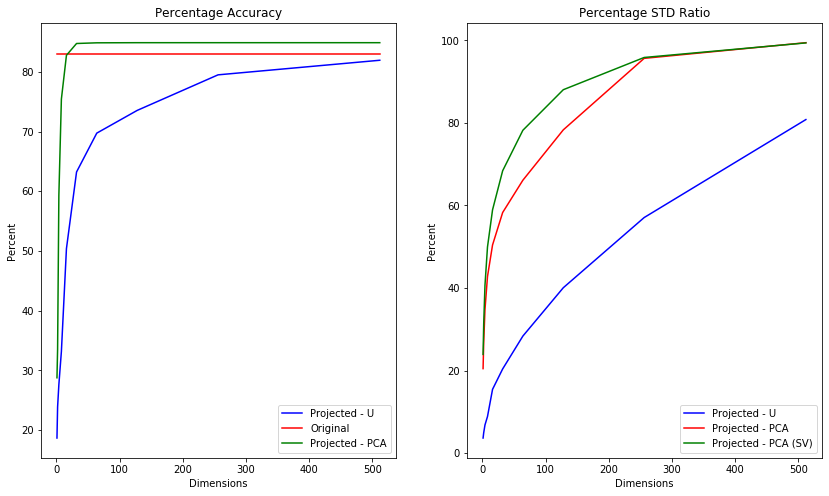

In [0]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize =(14,8))
axes[0].plot(dims, score, label = 'Projected - U', color="blue")
axes[0].plot(dims, hor, label='Original', color = "red")
axes[0].plot(dims, score_scnd, label = 'Projected - PCA', color = "green")
axes[0].set(title='Percentage Accuracy')
axes[0].legend()
axes[1].plot(dims, ratio_list, label = 'Projected - U', color = "blue")
axes[1].plot(dims, ratio_list_scnd, label = 'Projected - PCA', color = "red")
axes[1].plot(dims, ratio_pca_scnd, label = 'Projected - PCA (SV)', color = "green")
axes[1].set(title='Percentage STD Ratio')
axes[1].legend()
for axis in axes:
    axis.set(xlabel = 'Dimensions', ylabel='Percent')

This dimensionality reduction technique helps with computational efficiency, the running time is less. Also, the classification results are slightly better since we can achieve a 84.88% of accuracy. The dimensions that yeld the best performance are: 128, 256, and 512. Apparently, for computationally efficiency consideration, we will choose 128 and it indeed gives the best performance.

Finally, the two ratio plots from the PCA are not identical because when we calculate the ratio using singular values, we are considering the variance among each of the dimensions, then combine them to get the variance of the whole data. However, in the other case we calculate the variance at once considering all the data points.  

**Problem 1.4**

In [0]:
from skimage.feature import hog


In [0]:
def hog_encoding(sets_in, orientations, pixels_per_cell, cell_per_block, image_size=(28,28)):
    new_data = copy.deepcopy(sets_in)
    train = []
    for i in list(range(new_data.train.x.shape[0])):
        image = new_data.train.x[i,:].reshape(image_size)
        fd = hog(image, orientations = orientations, pixels_per_cell = pixels_per_cell, 
                            cells_per_block = cell_per_block, visualize = False, multichannel = None)
        train.append(fd)
    validate = []
    for i in list(range(new_data.validate.x.shape[0])):
        image = new_data.validate.x[i,:].reshape(image_size)
        fd = hog(image, orientations = orientations, pixels_per_cell = pixels_per_cell, 
                            cells_per_block = cell_per_block, visualize = False, multichannel = None)
        validate.append(fd)    
    test = []
    for i in list(range(new_data.test.x.shape[0])):
        image = new_data.test.x[i,:].reshape(image_size)
        fd = hog(image, orientations = orientations, pixels_per_cell = pixels_per_cell, 
                            cells_per_block = cell_per_block, visualize = False, multichannel = None)
        test.append(fd)
    new_data.train.x = np.array(train)
    new_data.validate.x = np.array(validate)
    new_data.test.x = np.array(test)
    return new_data

In [0]:
projected_set = hog_encoding(data, 5, (2,2), (1,1))


In [0]:
classifier = train(projected_set.train)
baseline_accuracy = percent_accuracy(classifier, projected_set.test)

Let's recall that every image is of dimension $(28\times28)$. Since we divide it in blocks of $(2\times2)$, we have $14\times14$ cells, and each cell with $(2\times2)$ pixels. Also we have 1 cell per block and each block has 8 values since we have 8 orientations (bins). In total we have $14\times14\times5\times1=980$ entries.  

In [0]:
dim = projected_set.train.x.shape[1]
print(dim)


980


In [0]:

print(f"The test accuracy is {baseline_accuracy}")
print(f"The dimension of the HOG descriptor is {dim}")
print("The hyperparameters are: orientation = 5, pixels per cell = (2, 2), and cells per block = (1, 1)")

The test accuracy is 72.14285714285714
The dimension of the HOG descriptor is 980
The hyperparameters are: orientation = 5, pixels per cell = (2, 2), and cells per block = (1, 1)


This dimensionality reduction technique does not help with computational efficiency, since the code takes more than one minute to run, also the classification results do not get better. 

##### **Part 2: An Iterative Linear Solver**

**Problem 2.1**

We can define:

$$
f(z)=||Az-b||^{2}
$$

where $||\cdot||$ denotes the Euclidean norm. 

Let's write a formula in terms of $A$, **b**, and **z** for the function:

$$
g(z)= \partial f(z) = 2 A^{T}(Az-b)
$$

the gradient of $f$ at $z$




In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def make_f(A, b):
    def f(z):
        return np.linalg.norm(np.dot(A, z) - b, 2) ** 2
    return f 

In [0]:
def make_g(A,b):
    A_t = A.transpose()
    def g(z):
        return 2*np.dot(A_t, (np.dot(A,z)-b))
    return g

In [0]:
def plot_bowl(f, z_star, rect):
    n=101
    xlist = np.linspace(rect[0],rect[1], n)
    ylist = np.linspace(rect[2],rect[3], n)
    X,Y = np.meshgrid(xlist,ylist)
    Z = np.zeros((n,n))
    for i in list(range(n)):
        for j in list(range(n)):
            Z[i][j]=f([X[i][j],Y[i][j]])
    cp = plt.contourf(X, Y, Z, 20, cmap=plt.get_cmap('gist_yarg'))
    plt.plot([z_star[0]], [z_star[1]], marker='o', markersize=3, color="red")
    plt.axis("scaled")
    plt.colorbar(cp)

In [0]:
A = np.array([[5.0214, 0.8648], [8.6478, -0.5021]])
b = np.zeros(2)
z_0 = np.array([1., -1.])
rect = [-2., 2., -2., 2.]


In [0]:
z_star, residuals, rank, s = np.linalg.lstsq(A,b) 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [0]:
f = make_f(A,b)

In [0]:
g = make_g(A,b)
g(z_0)

array([199.997,  -1.999])

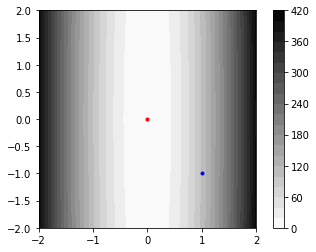

In [0]:
plot= plot_bowl(f,z_star,rect)
plt.plot([z_0[0]], [z_0[1]], marker='o', markersize=3, color="blue")


**Problem 2.2**

In [0]:
from scipy import optimize

#Returns the new point 
def line_search(f, g, z_0):
    f0, g0 = f(z_0), g(z_0)
    alpha = optimize.line_search(f, g, z_0, -g0, g0, f0)[0]
    return z_0 - g0 * alpha

In [0]:
def steepest(f,g,z_0, maxK=10000, delta = 1.e-8):
    z_k = z_0
    z_k_minus_1 = np.array([1,1])
    dist = np.linalg.norm(z_k-z_k_minus_1)
    i = 1 
    path = [z_k]
    while dist > delta and i < maxK:
        opt = line_search(f,g,z_k)
        z_k_minus_1 = z_k
        z_k = opt
        path = np.append(path,[z_k],0)
        dist = np.linalg.norm(z_k-z_k_minus_1)
        i +=1
    print("The number of steps is:")
    print(i)
    print("The entries of the last point are:")
    print(opt)
    return z_k, path

In [0]:
optimo, h = steepest(f,g,z_0)


The number of steps is:
67
The entries of the last point are:
[-2.006e-11 -3.406e-08]


In [0]:
def plot_history(h,f,z_star,rect):
    plot_bowl(f,z_star,rect)
    plt.plot([h[0][0]], [h[0][1]], marker='o', markersize=3, color="blue")
    plt.plot(h[:, 0], h[:, 1])
    plt.show()

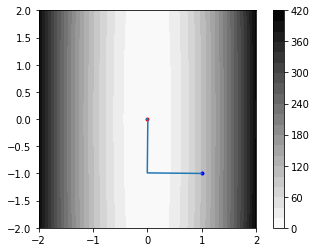

In [0]:
plot_history(h,f,z_star,rect)

**Problem 2.3**

In [0]:
print("The Condition Number of matrix A is:")
print(np.linalg.cond(A, p=None))

The Condition Number of matrix A is:
10.0000279005852


In [0]:
shape = A.shape
P = np.zeros(shape)
for i in list(range(A.shape[0])):
    P[i][i]=A[i][i]
P_inv = np.zeros(shape)
for i in list(range(A.shape[0])):
    P_inv[i][i]=1/P[i][i]
B= A.dot(P_inv)
print("The Condition Number of matrix B is:")
print(np.linalg.cond(B, p=None))

The Condition Number of matrix B is:
1.000088895664421


The smallest possible condition number any matrix can have is equal to 1. This is the case where all the singular values are equal and this yields to the smallest posible *conditions number*. By definition, the largest singular value is going to be at least as large as the smallest singular value. 

**Problem 2.4**

In [0]:
B= A.dot(P_inv)
y_0 = P.dot(z_0)

In [0]:
f_B = make_f(B,b)
g_B = make_g(B,b)
g_B(y_0)
y_star, residuals, rank, s = np.linalg.lstsq(B,b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [0]:
optimo_B, h_B = steepest(f_B,g_B,y_0)


The number of steps is:
4
The entries of the last point are:
[-1.166e-14  1.167e-13]


In [0]:
h_B = h_B.dot(P_inv)

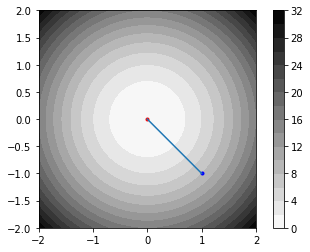

In [0]:
plot_history(h_B,f_B,y_star,rect)


We have a huge improvement in the number of steps, going from 67 to 4. The plot is well conditioned because the ellipses have nice shapes and are not very elongated. 

### Part 3: Miscellaneous Exam-Style Questions

**Problem 3.1**

![picture](https://drive.google.com/uc?id=1X9E4Sc9avpO5T2-PthL2FGd0ZXWH3j0e)

All the empirically optimal classifiers are $\{c\}$ and $\{c,d\}$. The statistically optimal classifiers is $\{a,c,d\}$.

**Problem 3.2**

We have a pixel of magnitude ($\mu$) 40 and orientation ($\theta$) 34 degrees. We can calculate first the bins:
$$
j = \big[\frac{\theta}{w}-\frac{1}{2}\big] \text{mod} B = 1
$$

$$
(j+1) \text{mod} B = 2 
$$
From the notes of the class we can calculate the contribution to each bin:


$$
v_{centered=30}=\mu \frac{c_{j+1}-\theta}{w} = v_{1} = 40\frac{(50-34)}{20}= 40(0.8)=32
$$

$$
v_{centered=50}=\mu \frac{\theta - c_{j}}{w}= 40\frac{(34-30)}{20}= 40(0.20) = 8 
$$

**Problem 3.3**


We need to find the minimum of the function:
$$
f(z)=\frac{x^{2}}{4}+\frac{y^{2}}{2}
$$
If calculate the gradient of this function we have:

 
$$
\begin{align}
\frac{\partial f(\cdot)}{\partial x}&: \frac{x}{2}\\
\frac{\partial f(\cdot)}{\partial y}&: y
\end{align}
$$

Formally, $\nabla(f)=(\frac{x}{2},y)$ and the direction of the line search is:
$p_k=(-\frac{x}{2},-y)$. Hence, the new point $z_{1}=(1,1)-\alpha(\frac{1}{2},1)=(1-\frac{\alpha}{2},1-\alpha)$. In order to find the optimal value of $\alpha$, we need to minimize the following expression:

$$
h(\alpha)=\frac{(1-\frac{\alpha}{2})^{2}}{4}+\frac{(1-\alpha)^{2}}{2}
$$

since the function is convex, we can take the first order condition and find the minimum:

$$
-0.25+0.125\alpha-1+\alpha=0
$$

and the solution is $\alpha^{*}=\frac{10}{9}$, hence $z_{1}=(\frac{4}{9},-\frac{1}{9})$

**Problem 3.4**


Let's recall that Newton's Method approximates a function by using a paraboloid in the region in which minimization is performed. Also, we can jump from $z_{0}$ to $z_{min}$ in only one step if the function is exactly a paraboloid (otherwise we will require to do some iterations). So, in our case the function $f(z)$ is a paraboloid, hence after one step we jump directly to the minimum $z_{1}=z_{min}=(0,0)$.